# Analisi dati dei contagi di COVID-19

- github : https://github.com/pcm-dpc/COVID-19
- datetime: https://pymotw.com/2/datetime/

In [1]:
import pandas as pd
import numpy as np
import datetime
import datetime #import date,datetime
import os.path
import sys
import matplotlib.pyplot as plt
from scipy.misc import derivative

In [2]:
def dropdata(df):
    df.drop(["data","stato","codice_regione","lat","long","note"],axis=1, inplace=True)
    return df

In [3]:
def getfile(date):
    return directory + tostr(date,es_fmt) + ".csv"

In [4]:
root_reg  = "dpc-covid19-ita-regioni-"
root_prov = "dpc-covid19-ita-province-"
latest_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/\
dati-regioni/dpc-covid19-ita-regioni-latest.csv"

github_fmt = "%Y%m%d"
es_fmt = "%Y-%m-%d"
plt_fmt = "%b %Y"

data_dir = "data/"
time_series_dir = "time series/"
reg_dir = "Regioni/"
prov_dir ="Province/"
raw_dir = "raw/"

first_day = datetime.date(year=2020, month=2, day=24)  # 24 febbraio 2020
today = datetime.date.today()
now = datetime.datetime.now()
if now.hour < 18 :
    #yesterday
    today = today - datetime.timedelta(days=1)
today = datetime.date(year=today.year, month=today.month,
                      day=today.day)  # today
one_day = datetime.timedelta(days=1)

print("first day   :", first_day)
print("today       :", today)
print("passed days :", (today - first_day).days)

first day   : 2020-02-24
today       : 2021-03-02
passed days : 372


In [5]:
def tostr(date,fmt=github_fmt):
    return date.strftime(fmt)

In [6]:
# https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python/1392549
def get_size(start_path = '.',unit="bytes"):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    if unit == "bytes" :
        return total_size
    elif unit == "Kb" or unit == "Kilobytes" :
        return total_size/1024

## Regioni

### Preparazione

In [7]:
lista_reg = list( [ 'Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', \
             'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', \
             'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto' ])

### Download

In [8]:
# impostazione per sovrascrivere i file
overwrite = False

In [9]:
#
directory = data_dir + reg_dir + raw_dir

#
N = (today - first_day).days
k=0
for i in range(N+1):
    date      = first_day + i*one_day 
    file_path = getfile(date)
    if False == os.path.exists(file_path) and overwrite == False:
        k=k+1
        print("Downloading file (",i+1,"/",N,"): ",tostr(date,es_fmt),end="\r")        
        url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/'\
        +root_reg+tostr(date,github_fmt)+".csv"
        # i valori sono interi
        df  = pd.read_csv(url)
        df = dropdata(df)
        df.to_csv(file_path,index=False)
print("\nDone (downloaded file: ",k,")")
print("Folder size : ",get_size(directory,"Kb")," Kb")

Done (downloaded file:  6 )
Folder size :  748.1591796875  Kb


### Dataframe di esempio

In [10]:
df = pd.read_csv(getfile(today))
#df

In [11]:
print(list(df["denominazione_regione"]))

['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']


### Serie storiche

https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [12]:
cols = [ 'ricoverati_con_sintomi' , 'terapia_intensiva' , \
        'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',\
        'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',\
        'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',\
        'totale_casi', 'tamponi', 'casi_testati']# + 'denominazione_regione'

In [13]:
# per ogni variabile creo un file con:
# colonne : data, tutte le regioni
# righe   : date
overwrite = False

# ciclo sulle variabili
N = (today - first_day).days
k=0
for c in cols:
    #
    print(k+1,"/",len(cols),"(",c,")",end="\r")
    # nome del file contenente il dataframe
    outname = c + ".csv" 
    outdir  = data_dir + reg_dir + time_series_dir
    file_time_series = os.path.join(outdir, outname)  
    #file_time_series = data_dir + reg_dir + time_series_dir + c + ".csv"
    # controllo se ho già creato questo file
    if os.path.exists(file_time_series) is True and overwrite is False :
        #print("Read")
        # in caso affermativo lo leggo e lo agggiorno
        time_series = pd.read_csv(file_time_series)
        time_series.set_index("Data",inplace=True,drop=False)
    else:
        # in caso negativo creo da zero il dataframe
        time_series = pd.DataFrame()
        time_series["Data"] = []
        for i in lista_reg:
            time_series[i] = []
        time_series.set_index("Data",inplace=True,drop=False)

    # ciclo su tutte le date (mancanti) ed inserisco i dati
    stampa_primo = False
    for i in range(N+1):
        #
        date = first_day + i * one_day
        date_str = tostr(date, es_fmt)
        #
        if stampa_primo is True :
            string = str(k+1)+"/"+str(len(cols))+" ("+ str(c)+") | date ("+str(i+1)+"/"+str(N)+"): "+date_str+"    "# \
            #+str(S)+str(stampa_primo)
            print(string,end="\r",flush=True)                
        
        # cerco se ho già la data
        if date_str in time_series["Data"] and overwrite is True:
            time_series = time_series.drop(date_str)
        #
        if date_str not in time_series["Data"] or overwrite is True:
            #if stampa_primo is False :
            stampa_primo = True
            #S = i
            #print("ciao")
            file_path = getfile(date)
            df = pd.read_csv(file_path)
            df = df.set_index("denominazione_regione")
            # aggiungo la data
            append = {"Data": date_str }
            for j in lista_reg :
                 append[j] = df[c][lista_reg][j]
            time_series = time_series.append(append,ignore_index=True)
            # aggiungo i valori per ogni regione
            #time_series.iloc[date_str,lista_reg] = list(df[c][lista_reg])
            #del df
    
    #
    print("")
    time_series.to_csv(file_time_series,index=False)
    k=k+1

1/14 (ricoverati_con_sintomi) | date (373/372): 2021-03-02    
2/14 (terapia_intensiva) | date (373/372): 2021-03-02    
3/14 (totale_ospedalizzati) | date (373/372): 2021-03-02    
4/14 (isolamento_domiciliare) | date (373/372): 2021-03-02    
5/14 (totale_positivi) | date (373/372): 2021-03-02    
6/14 (variazione_totale_positivi) | date (373/372): 2021-03-02    
7/14 (nuovi_positivi) | date (373/372): 2021-03-02    
8/14 (dimessi_guariti) | date (373/372): 2021-03-02    
9/14 (deceduti) | date (373/372): 2021-03-02    
10/14 (casi_da_sospetto_diagnostico) | date (373/372): 2021-03-02    
11/14 (casi_da_screening) | date (373/372): 2021-03-02    
12/14 (totale_casi) | date (373/372): 2021-03-02    
13/14 (tamponi) | date (373/372): 2021-03-02    
14/14 (casi_testati) | date (373/372): 2021-03-02    


### Calcolo di nuove serie storiche

#### Preparazione

In [14]:
overwrite = True

In [15]:
def media_mobile(file_in,file_out,N=7):
    #file nuovi deceduti
    file_nuovi_deceduti = os.path.join(outdir, file_in)   
    #leggo il dataframe
    nuovi_deceduti      = pd.read_csv(file_nuovi_deceduti)
    #calcolo la media mobile
    mm_nd = nuovi_deceduti.rolling(N,min_periods=1,center=False).mean()
    #aggiungo colonna Data
    mm_nd["Data"] = nuovi_deceduti["Data"]
    #riordino colonne
    cols = mm_nd.columns
    mm_nd = mm_nd[list(["Data"]) + list(cols)]
    #file media mobile nuovi deceduti
    file_mm_nd = os.path.join(outdir, file_out)   
    #salvo su file
    mm_nd.to_csv(file_mm_nd,index=False)

#### Nuovi deceduti

In [16]:
#file deceduti
file_deceduti = os.path.join(outdir, "deceduti.csv")   
df = pd.read_csv(file_deceduti)
df.set_index("Data",inplace=True,drop=True)

#file nuovi deceduti
file_time_series = os.path.join(outdir, "nuovi_deceduti.csv") 
if os.path.exists(file_time_series) == True and overwrite == False :
    time_series = pd.read_csv(file_time_series)
    time_series.set_index("Data",inplace=True,drop=True)
    
    #prendo l'ultima riga
    start = len(time_series)-1
    
    #aggiungo le righe mancanti
    dfi = df.index
    tsi = time_series.index
    newdates = [ a for a in dfi if a not in tsi ]
    empty = np.zeros(len(cols))
    for nd in newdates:
        time_series.loc[nd,:] = empty
else :
    time_series = df.copy()
    
    #copio la prima riga
    first = df.first_valid_index()
    time_series.loc[first] = df.loc[first]
    start = 1

#calcolo la differenza
for i in range(start,len(df)):
    time_series.iloc[i] = df.iloc[i] - df.iloc[i-1]
    
#aggiungo la data e riordino le colonne
cols = time_series.columns
time_series['Data'] = time_series.index
time_series = time_series[list(["Data"]) + list(cols)]

#salvo su file
time_series.to_csv(file_time_series,index=False)  

#### Media mobile (settimanale) nuovi deceduti

In [17]:
media_mobile(file_in="nuovi_deceduti.csv",file_out="nuovi_deceduti_mm.csv")

#### Media mobile (settimanale) nuovi positivi

In [18]:
media_mobile(file_in="nuovi_positivi.csv",file_out="nuovi_positivi_mm.csv")

#### Nuovi tamponi

In [19]:
#file tamponi
file_tamponi = os.path.join(outdir, "tamponi.csv")   
df = pd.read_csv(file_tamponi)
df.set_index("Data",inplace=True,drop=True)

#file nuovi tamponi
file_time_series = os.path.join(outdir, "nuovi_tamponi.csv")   
if os.path.exists(file_time_series) is True and overwrite is False :
    time_series = pd.read_csv(file_time_series)
    time_series.set_index("Data",inplace=True,drop=True)
    
    #prendo l'ultima riga
    start = len(time_series)-1
    
    #aggiungo le righe mancanti
    dfi = df.index
    tsi = time_series.index
    newdates = [ a for a in dfi if a not in tsi ]
    empty = np.zeros(len(cols))
    for nd in newdates:
        time_series.loc[nd,:] = empty
    
else :
    time_series = df.copy()
    
    #copio la prima riga
    first = df.first_valid_index()
    time_series.loc[first] = df.loc[first]
    start = 1

    
#calcolo la differenza
for i in range(start,len(df)):
    time_series.iloc[i] = df.iloc[i] - df.iloc[i-1]


#aggiungo la data e riordino le colonne
cols = time_series.columns
time_series['Data'] = time_series.index
time_series = time_series[list(["Data"]) + list(cols)]

#salvo su file
time_series.to_csv(file_time_series,index=False)  

#### Nuovi tamponi (media mobile settimanale)

In [20]:
media_mobile(file_in="nuovi_tamponi.csv",file_out="nuovi_tamponi_mm.csv")

#### Percentuale nuovi tamponi positivi

In [21]:
#file nuovi positivi
file_nuovi_positivi = os.path.join(outdir, "nuovi_positivi.csv")   
#leggo il dataframe
nuovi_positivi      = pd.read_csv(file_nuovi_positivi)
nuovi_positivi.set_index("Data",inplace=True,drop=True)

#file nuovi tamponi
file_tamponi = os.path.join(outdir, "tamponi.csv")  
#leggo il dataframe
nuovi_tamponi = pd.read_csv(file_tamponi)
nuovi_tamponi.set_index("Data",inplace=True,drop=True)
#percentuale nuovi tamponi positivi
pntp = 100 * nuovi_positivi / nuovi_tamponi
#aggiungo colonna Data e riordino colonne
cols = pntp.columns
pntp["Data"] = nuovi_tamponi.index
pntp = pntp[list(["Data"]) + list(cols)]
#file percentuale nuovi tamponi positivi
file_pntp = os.path.join(outdir, "perc_nuovi_tamponi_positivi.csv")   
#salvo su file
pntp.to_csv(file_pntp,index=False)

#### Percentuale nuovi tamponi positivi (media mobile settimanale)

In [22]:
media_mobile(file_in="perc_nuovi_tamponi_positivi.csv",file_out="perc_nuovi_tamponi_positivi_mm.csv")

### Confronto regioni

#### Preparazione

In [23]:
regs  = ["Piemonte","Lombardia","Veneto","Lazio","Campania",'Emilia-Romagna','Campania','Puglia','Sicilia']
#lista_reg
regs_nord = ['Friuli Venezia Giulia','Liguria', 'Lombardia','P.A. Bolzano', 'P.A. Trento', \
             'Piemonte','Valle d\'Aosta', 'Veneto']
regs_centro = ['Abruzzo','Emilia-Romagna','Lazio','Marche','Molise','Toscana', 'Umbria']
regs_sud = ['Basilicata', 'Calabria', 'Campania','Puglia','Sardegna', 'Sicilia']
#lista_reg

In [24]:
cols

Index(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d'Aosta', 'Veneto'],
      dtype='object')

In [25]:
def plt_time_series(var,regs,title,xmin=None):
    outname = var + ".csv" 
    outdir  = data_dir + reg_dir + time_series_dir
    file_time_series = os.path.join(outdir, outname) 

    #
    ts = pd.read_csv(file_time_series)
    
    #
    if xmin is not None :
        ts = ts[ts["Data"] >= xmin]
    
    #
    xticks = [ i for i in ts["Data"] if datetime.datetime.strptime(i,es_fmt).day == 1 ]
    xlabel = [ datetime.datetime.strftime(datetime.datetime.strptime(i,es_fmt),plt_fmt) for i in xticks ]

    #
    fig, ax = plt.subplots(figsize=(15, 5)) #plt.figure()
    for r in regs :
        plt.plot(ts["Data"],ts[r],label=r)

    plt.xticks(ticks=xticks,labels=xlabel,rotation=45)
    #plt.legend(loc="upper center")
    plt.legend(loc="upper left",bbox_to_anchor= (1, 1))
    plt.title(title)
    plt.grid(True)
    plt.show()

#### Totale positivi

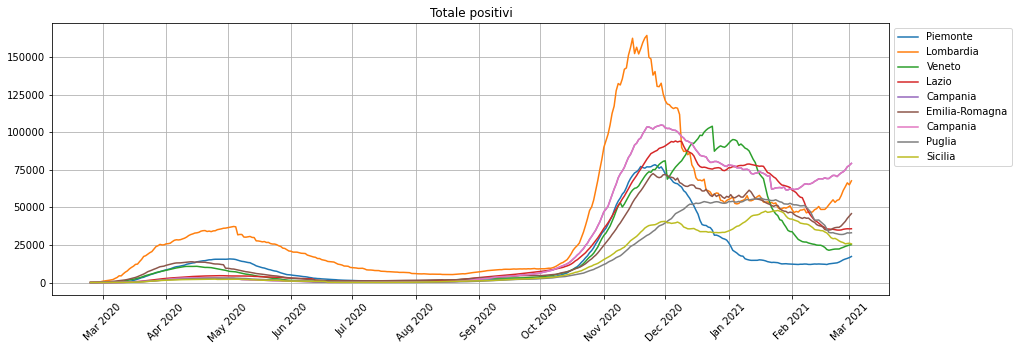

In [26]:
plt_time_series( var= "totale_positivi",regs=regs,title = "Totale positivi")

#### Nuovi positivi

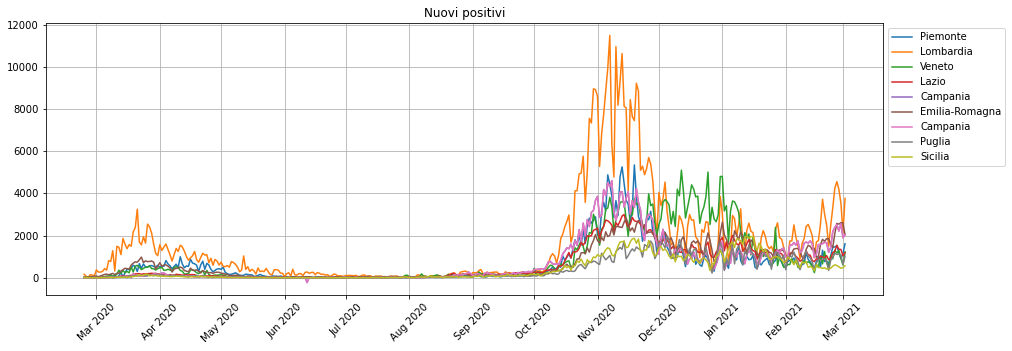

In [27]:
plt_time_series( var= "nuovi_positivi",regs=regs,title = "Nuovi positivi") 

#### Nuovi positivi (media mobile settimanale)

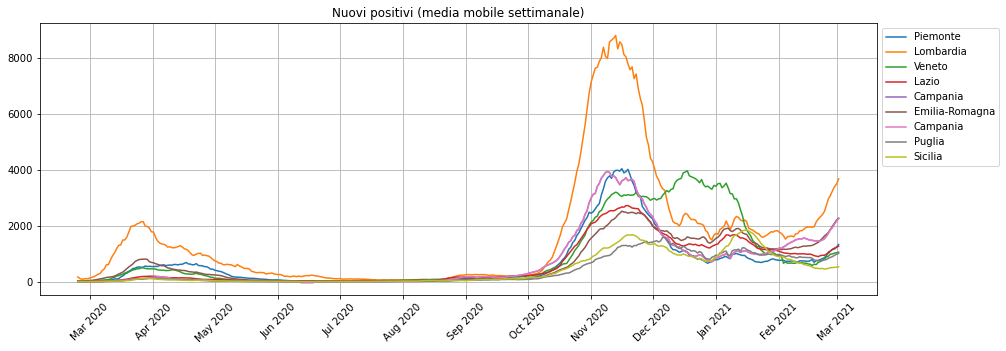

In [28]:
plt_time_series( var= "nuovi_positivi_mm",regs=regs,title = "Nuovi positivi (media mobile settimanale)") 

#### Terapie intensive

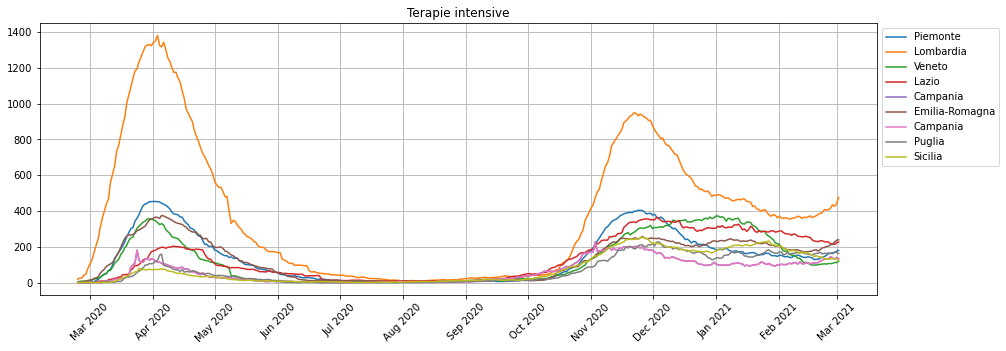

In [29]:
plt_time_series( var= "terapia_intensiva",regs=regs,title = "Terapie intensive")

#### Nuovi deceduti

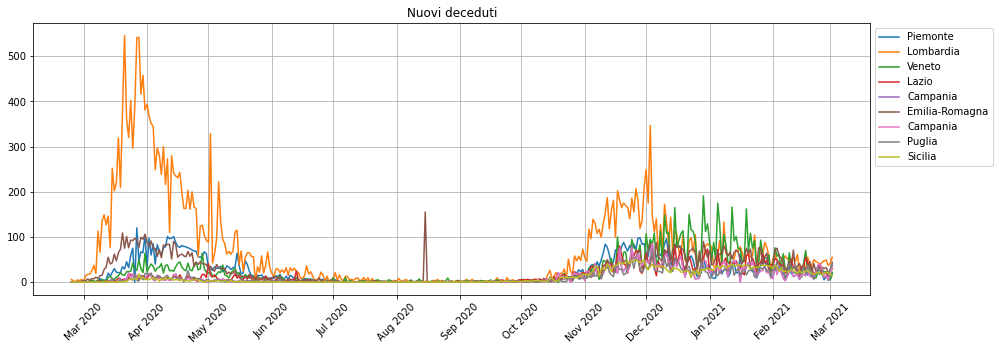

In [30]:
plt_time_series( var= "nuovi_deceduti",regs=regs,title = "Nuovi deceduti")

#### Nuovi deceduti (media mobile settimanale)

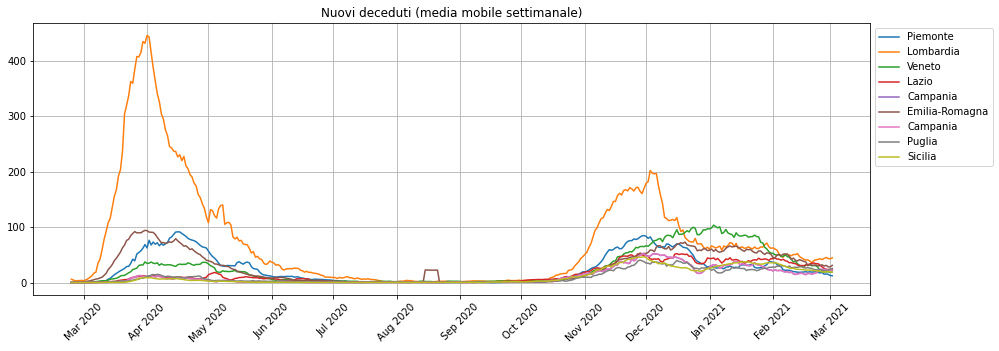

In [31]:
plt_time_series( var= "nuovi_deceduti_mm",regs=regs,title = "Nuovi deceduti (media mobile settimanale)")

#### Nuovi tamponi

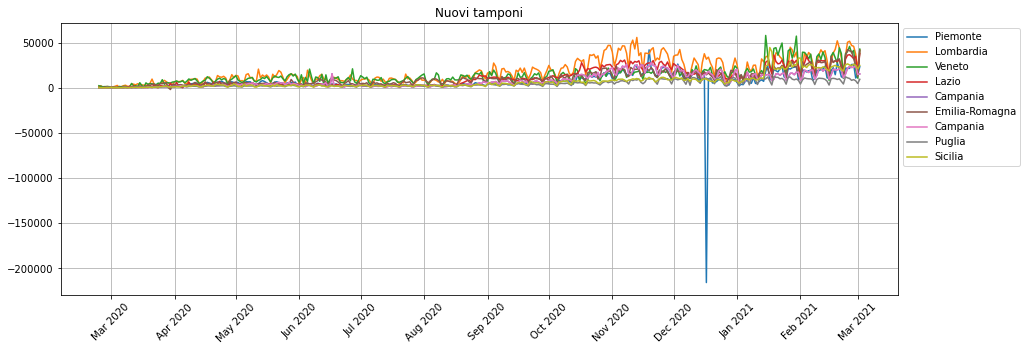

In [32]:
plt_time_series( var= "nuovi_tamponi",regs=regs,title = "Nuovi tamponi")

#### Nuovi tamponi (media mobile settimanale)

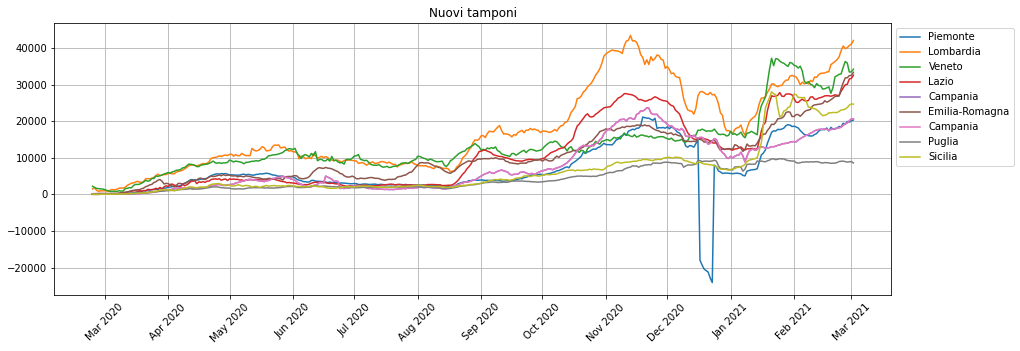

In [33]:
plt_time_series( var= "nuovi_tamponi_mm",regs=regs,title = "Nuovi tamponi")

#### Percentuale nuovi tamponi positivi (media mobile settimanale)

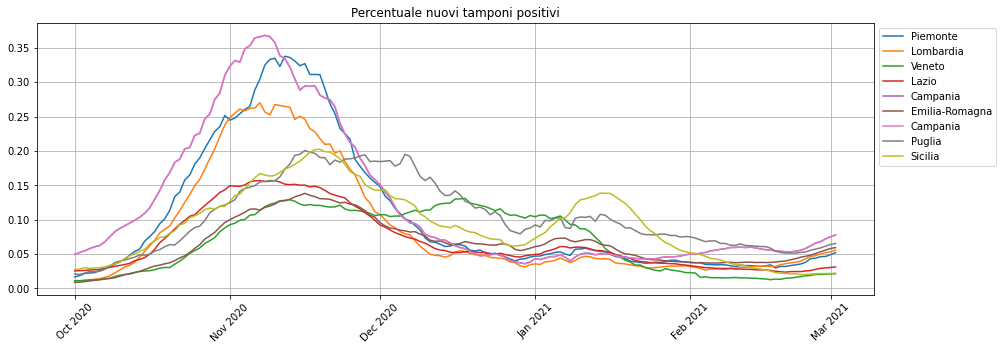

In [34]:
plt_time_series( var= "perc_nuovi_tamponi_positivi_mm",\
                regs=regs,title = "Percentuale nuovi tamponi positivi",\
               xmin="2020-10-01")